In [1]:
%matplotlib inline
import ggplot
import holidays

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.sandbox.gam import AdditiveModel

from scipy.spatial import distance
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax

from matplotlib import animation

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

plt.style.use('ggplot')

### Get data

In [2]:
def get_data(nrows):
    data = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
    data['timestamp'] = pd.to_datetime(
        data.apply(lambda x: "{}/{}/01".format(x['year'], x['month']), axis=1), 
        format="%Y/%B/%d")

    data = data.set_index('timestamp').tz_localize('UTC').drop(['year', 'month'], axis=1)
    data.columns = ['value']
    data = data.resample('H').interpolate('linear')
    return data

In [3]:
data = get_data(nrows=None)

In [4]:
data.head()

,value
timestamp,
1949-01-01 00:00:00+00:00,112.000000
1949-01-01 01:00:00+00:00,112.008065
1949-01-01 02:00:00+00:00,112.016129
1949-01-01 03:00:00+00:00,112.024194
1949-01-01 04:00:00+00:00,112.032258


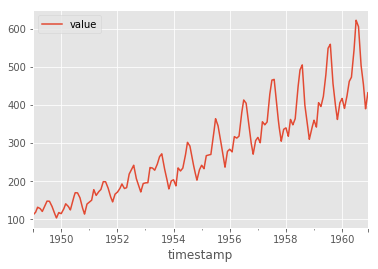

In [5]:
data.plot()

### Get features

In [37]:
def flag_holidays(data):
    # Flag Holidays
    df = data.copy()
    df['isHoliday'] = pd.Series(df.index.date).isin(holidays.France(years=np.unique(df.index.year))).values
    return df
        

def extract_statistical_features(x):
    """Simple statistical features"""
    out = x.describe()
    out['sum'] = x.sum()
    out['median'] = x.median()
    out['skew'] = x.skew()
    out['kurtosis'] = x.kurtosis()
    out.rename_axis({'25%': 'time_25%', '50%': 'time_50%', '75%': 'time_75%'}, inplace=True)

    return out.to_dict()

# def extract_time_features(x):
#     # Time series analysis related features
#     out['autocorr_1h'] = x.autocorr(6)
#     out['autocorr_6h'] = x.autocorr(6 * 6)
#     out['autocorr_12h'] = x.autocorr(6 * 12)
#     out['mean_abs_1diff'] =  x.diff(1).abs().mean()
#     out['mean_abs_2diff'] =  x.diff(2).abs().mean()

def extract_frequency_features(x):
    """Frequency domain related features"""
    fourier_data = pd.DataFrame({'spec': np.abs(np.fft.fft(x, 512, axis=-1))})
    fourier_data['freq'] = np.fft.fftfreq(len(fourier_data))
    fourier_data = fourier_data[fourier_data['freq'] >= 0]
    fourier_data['power_spec'] = fourier_data.eval('spec**2')

    freq_max = fourier_data.sort_values('spec', ascending=False).head(10)['freq']
    freq_max.reset_index(drop=True, inplace=True)
    freq_max.index = ('freq_peak_' + (freq_max.index + 1).astype('str'))

    freq_quant = fourier_data['spec'].quantile([0.25, 0.5, 0.75])
    freq_quant.index = ['freq_25%', 'freq_50%', 'freq_75%']

    out = pd.concat([freq_max, freq_quant])

    return out.to_dict()

def extract_datetime_features(x):
    """ Datetime components"""
    out = x.copy()
    out['year'] = x.index.year
    out['month'] = x.index.month
    out['day'] = x.index.day
    out['hour'] = x.index.hour
    out['weekday'] = x.index.weekday + 1
    out['weekend'] = out['weekday'].isin([6, 7])
    out = flag_holidays(out)

    return out


class Poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly/

    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree = 1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if(degree >= len(np.unique(x))):
            raise("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        X = np.fliplr(np.vander(x, n))
        q, r = np.linalg.qr(X)

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x,(-1, 1)), axis=0)/norm2 + xbar)[:degree]
        Z = raw / np.sqrt(norm2)

        self.z = Z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        Z = np.empty((len(x), n))
        Z[:,0] = 1

        if self.degree > 0:
            Z[:, 1] = x - self.alpha[0]

        if self.degree > 1:

            for i in np.arange(1, self.degree):
                Z[:, i+1] = (x - self.alpha[i]) * Z[:, i] - (self.norm2[i] / self.norm2[i-1]) * Z[:, i-1]

        Z /= np.sqrt(self.norm2)

        return Z
    

def run_length_encoding(x):
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0],pos+1,[len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a,b) in zip(pos[:-1],pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial = False):
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    if not ind.size: # prevent index error if ind is empty
        return np.zeros_like(x, dtype=bool) | initial
    cnt = np.cumsum(lo_or_hi) # from 0 to len(x)
    return np.where(cnt, hi[ind[cnt-1]], initial)


# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return(trim_x)


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr/width)

    varx = np.zeros(nsegs)

    for idx in range(int(nsegs)):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = pd.Series(tmp).rolling(window=width, center=False).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = pd.Series(tmp).rolling(window=width, center=False).mean()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() -  x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)

        rle_x = run_length_encoding(cut_x)
        flat_spots = max(rle_x)

    except Exception:
        flat_spots = np.nan

    #  Any flat spot
    return flat_spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)

    if (length_cont_x < 2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if (freq > 1):
            all_stl = sm.tsa.seasonal_decompose(cont_x, freq=freq)

            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else: # No seasonal component
            tt = np.array([range(length_cont_x)]).T


            trend0 = AdditiveModel(tt).fit(cont_x.tolist()).mu
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d)/(n - 2)
        spike = varloo.var()
        pl = Poly()
        pl.fit(range(length_cont_x), degree = 2)
        result_pl = pl.predict(range(length_cont_x)) #[:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend = trend, spike = spike, peak = peak, trough = trough, linearity = linearity,
                curvature = curvature)

    if (freq > 1):
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step = (x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise Exception("I cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)

    rmean = pd.Series(dens_mat).rolling(window=window, center=False).mean()

    lo = range(len_x - window + 1)
    hi = range(window + 1, len_x)
    seqidx = min(len(lo), len(hi))

    kl = np.zeros(seqidx)
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)

    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)

    return dict(score = np.max(diffkl), change_idx = maxidx)

# TODO: finish translation from R into Python

def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)

# # spectral_entropy from ForeCA package
# Entropy <- function(x) {
#   entropy <- try(ForeCA::spectral_entropy(na.contiguous(x))[1L], silent = TRUE)
#   if (class(entropy) == "try-error") {
#     entropy <- NA
#   }
#   return(entropy)
# }


def extract_time_series_features(x, freq, normalize = True, width = None, window = None):
    # y: a multivariate time series
    # normalize: TRUE: scale data to be normally distributed
    # width: a window size for variance change and level shift, lumpiness
    # window: a window size for KLscore

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1 | window <= 1):
        raise Exception("window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise Exception("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width = width)
    # measures['entropy'] = apply(x, 2, Entropy)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width = width)
    measures['vchange'] = rolling_variance_change(trimx, width = width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if (freq > 1):
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window = window, threshold = threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] =  kl['change_idx']
    except:
#         print('KL Score was not calculated')
        pass

    measures['boxcox'] = boxcox_optimal_lambda(x)

    return(measures)


# Main functions
def get_features_dict(x):
    """ Get feature's dictionary
    :param x: pandas series
    :return: feature dictionary
    """
    features = extract_time_series_features(x, freq=24*30*3, width=36)
    features.update(extract_frequency_features(x))
    features.update(extract_statistical_features(x))
    return features


def compute_features(data, target='value'):
    """
    :param data: pandas dataframe. it has to be time indexed
    :return: dataframe of features (1 feature by column)
    """
    def finish(x):
        if len(x.columns) == 3:
            x.columns = ['time', 'feature', 'value']
            return x.pivot('time', 'feature', 'value')
        else: 
            return x.drop('level_1', axis=1)
    
    def process(x, target='value'):
        return pd.Series(get_features_dict(x[target])).to_frame().transpose()
        
    return (
        data
        .dropna()
        .resample('QS')
        .apply(process)
        .reset_index()
        .pipe(finish) 
    )

In [38]:
df = compute_features(data.copy())
df = (
    df[df['count'] > (df['count'].max() * 0.95)]
    .drop(['count'], axis=1)
    .set_index('timestamp')
    .dropna(axis=1, how='all')
    .dropna(axis=0)
)

features = df.columns

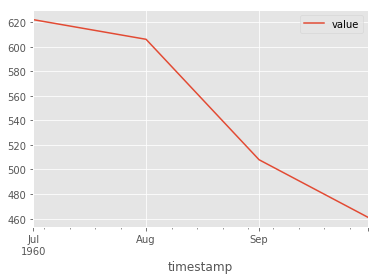

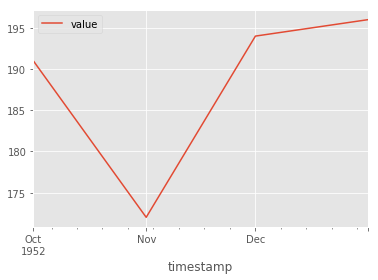

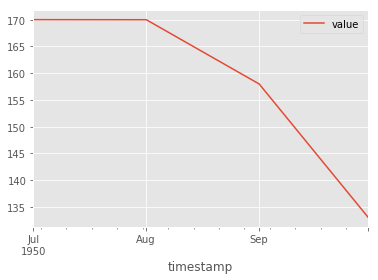

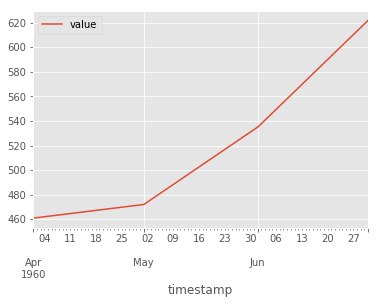

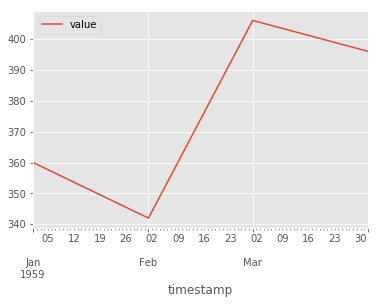

In [36]:
grouped = data.dropna().resample('QS')
for i, idx in enumerate(grouped.groups):
    if (i % 10) == 0:
        _d = grouped.get_group(idx)
        _d.plot()

In [39]:
df.head()

,ACF1,boxcox,cpoints,freq_25%,freq_50%,freq_75%,freq_peak_1,freq_peak_10,freq_peak_2,freq_peak_3,...,mean,median,min,skew,std,sum,time_25%,time_50%,time_75%,vchange
timestamp,,,,,,,,,,,,,,,,,,,,,
1949-01-01 00:00:00+00:00,0.999999,0.571907,1.0,2.238918,2.928707,5.415146,0.0,0.017578,0.001953,0.003906,...,123.446065,124.989583,112.000000,-0.242859,6.991452,266643.5,116.352823,124.989583,130.174395,0.037500
1949-04-01 00:00:00+00:00,0.999999,0.380886,1.0,3.084732,4.035108,7.460868,0.0,0.017578,0.001953,0.003906,...,131.457189,128.627778,121.000000,0.557035,7.937257,287102.5,124.817697,128.627778,138.128125,0.025106
1949-07-01 00:00:00+00:00,1.000000,1.299661,1.0,0.000000,0.000000,0.000000,0.0,0.330078,0.001953,0.316406,...,139.300045,142.201613,119.023611,-0.700621,9.231696,307574.5,132.051042,142.201613,148.000000,0.029334
1949-10-01 00:00:00+00:00,0.999993,2.186346,2.0,5.597296,7.321768,13.537865,0.0,0.017578,0.001953,0.003906,...,113.022645,114.927599,104.000000,-0.626880,4.254637,249554.0,109.463844,114.927599,116.560641,0.048387
1950-01-01 00:00:00+00:00,0.999999,1.218425,1.0,4.104684,5.369297,9.927768,0.0,0.017578,0.001953,0.003906,...,130.567593,133.488839,115.000000,-0.426280,8.187594,282026.0,122.980175,133.488839,137.800403,0.030907


In [40]:
list(features)

['ACF1',
 'boxcox',
 'cpoints',
 'freq_25%',
 'freq_50%',
 'freq_75%',
 'freq_peak_1',
 'freq_peak_10',
 'freq_peak_2',
 'freq_peak_3',
 'freq_peak_4',
 'freq_peak_5',
 'freq_peak_6',
 'freq_peak_7',
 'freq_peak_8',
 'freq_peak_9',
 'fspots',
 'kurtosis',
 'lshift',
 'lumpiness',
 'max',
 'mean',
 'median',
 'min',
 'skew',
 'std',
 'sum',
 'time_25%',
 'time_50%',
 'time_75%',
 'vchange']

### Preprocessing

In [41]:
# X = df['2014'].as_matrix()
# labels_true = (df['2014'].index.dayofweek + 1).astype(str)
X = df.as_matrix()
labels_true = (df.index.dayofweek + 1).astype(str)
X_scaled = scale(X)

pca = PCA().fit(X_scaled)
X_reduced = pca.transform(X_scaled)

n_samples, n_features = X_reduced.shape

use_principal_components = [0, 1]
tag = pd.Index(['PC']) + (np.array(use_principal_components) + 1).astype(str)
tag = tag.tolist()
data_reduced = pd.DataFrame(X_reduced[:, use_principal_components], columns=tag)
data_reduced = pd.concat([data_reduced,
                          pd.DataFrame(labels_true, columns=['label']),
                          pd.DataFrame(df.index.year.astype(str), columns=['year']),
                          pd.DataFrame(df.index.month.astype(str), columns=['month'])], axis=1)

In [42]:
data_reduced.head()

,PC1,PC2,label,year,month
0,2.335947,-2.087976,6,1949,1
1,1.798139,-1.733827,5,1949,4
2,9.427294,4.430772,5,1949,7
3,2.990275,-5.089611,6,1949,10
4,2.237702,-2.177388,7,1950,1


In [43]:
def compute_dbscan(X_reduced, eps=None):
    """Compute DBSCAN"""
    D = distance.squareform(distance.pdist(X_reduced[:, 0:3]))
    S = np.max(D) - D

    if eps is None:
        eps = np.max(D)

    dbscan = DBSCAN(eps = eps, min_samples=10, metric='euclidean')
    dbscan.fit(S)
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    labels = dbscan.labels_
    return labels


def plot_dbscan_result(x, labels, variables=None):

    if variables is None:
        variables = [0,1]

    core_samples_mask = np.zeros_like(labels, dtype=bool)

    vx = variables[0]
    vy = variables[1]

    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # plt.figure()
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = x[class_member_mask & core_samples_mask]
        plt.plot(xy[:, vx], xy[:, vy], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)

        xy = x[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, vx], xy[:, vy], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)

    # plt.show()


def score_dbscan(labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters_ > 1:
        print('Estimated number of clusters: %d' % n_clusters_)
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
        print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
        print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
        print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
        print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


def animate_dbscan(nframe):

    eps = nframe #5.0/(nframe + 1)
    labels = compute_dbscan(X_reduced, eps)

    plt.cla()
    plot_dbscan_result(X_reduced, labels, variables=[0, 1])
    plt.title('Epsilon = %.4f' % eps)

    return labels

Color by label


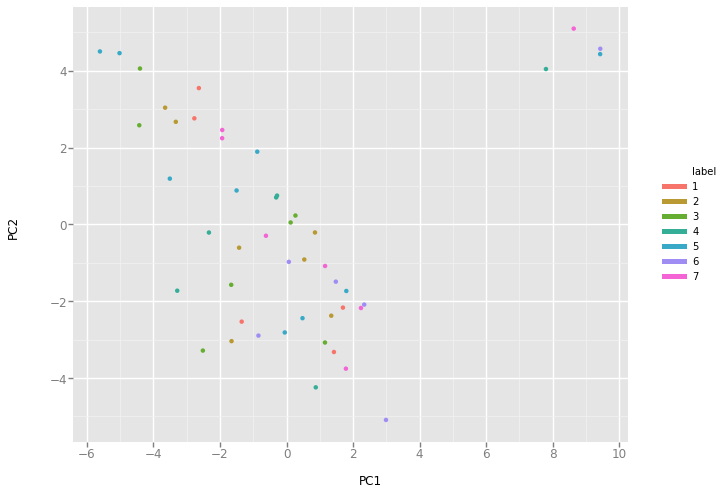

<ggplot: (8768979321159)>


In [44]:
print('Color by label')
print(ggplot.ggplot(ggplot.aes(x=tag[0], y=tag[1], colour='label'), data = data_reduced) + ggplot.geom_point())

Color by year


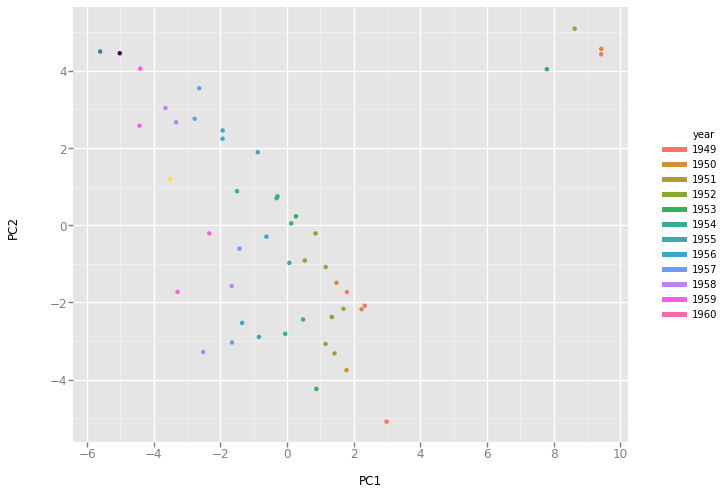

<ggplot: (8768980157476)>


In [45]:
print('Color by year')
print(ggplot.ggplot(ggplot.aes(x=tag[0], y=tag[1], colour='year'), data = data_reduced) + ggplot.geom_point())

Color by month


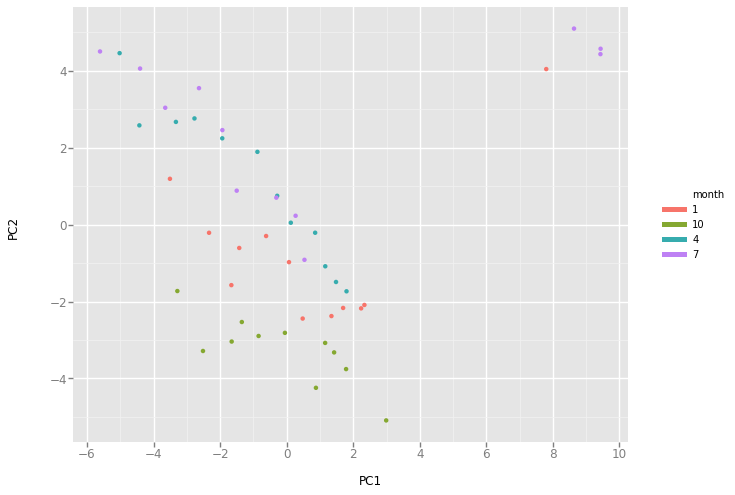

<ggplot: (-9223363267875538116)>


In [46]:
print('Color by month')
print(ggplot.ggplot(ggplot.aes(x=tag[0], y=tag[1], colour='month'), data = data_reduced) + ggplot.geom_point())

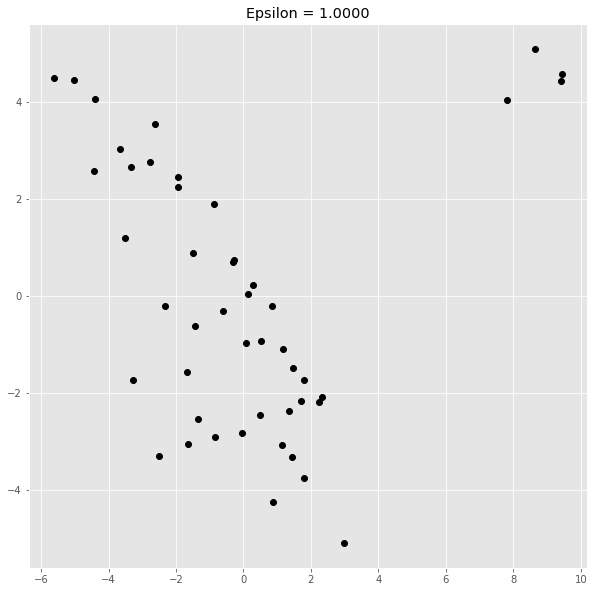

In [47]:
# Animation
fig = plt.figure(figsize=(10, 10))
anim = animation.FuncAnimation(fig, animate_dbscan, frames=np.arange(1, 40, 1))

labels = animate_dbscan(2.0)
df[labels == -1]
plot_dbscan_result(X_reduced, labels, variables=[0,1])

In [ ]:
# TODO: implement convex hulls and/or High Density Regions for anomaly detection